**Autor:** [Matej Uhrin](mailto:5283652@upjs.sk)

**Podporné materiály k bakalárskej práci <i>Simulácie vybraných stochastických procesov v interaktívnom prostredí</i>**

***

<br>

**<font size=10 color=brown> Nehomogénny Poissonov proces</font>**

<br>

<a id=table_of_contents></a>
##  Obsah
* [Algoritmus simulácie zamietacou metódou](#algo_reject)
* [Algoritmus simulácie inverznou transformáciou (Klein a Roberts)](#algo_inverse)
* [Simulácia futbalového zápasu](#football)

<font size=3>Pre návrat na obsah stlačte klávesu Home.</font>
---

In [1]:
# nacitanie balikov
import numpy as np
import matplotlib.pyplot as plt


# pomocne metody na vykreslovanie
def plot_football_intensity_function(xp, yp):
    plt.figure(figsize=(8, 4))
    plt.plot(xp[:4], yp[:4], color="blue")
    plt.plot(xp[4:], yp[4:], color="blue")
    plt.ylim(0, 0.05)
    plt.xticks([0, 15, 30, 45, 60, 75, 90, 95])
    for x in [0, 15, 30, 45, 60, 75, 90, 95]:
        plt.axvline(x, ymax=intensity_f(x) * 20, alpha=0.5, color="gray", ls="--")
    plt.fill_between(xp, yp, np.zeros_like(xp), alpha=0.05, color="blue")
    plt.xlabel("Minúta zápasu", size=10)
    plt.ylabel("Intenzita gólov", size=10)
    plt.title("Funkcia intenzity gólov vo futbalovom zápase", size=10)
    plt.show()


def football_goal_timeline(goals):
    fig, ax = plt.subplots(figsize=(10, 1))
    plt.xlim(0, 95)
    plt.ylim(-0.75, 0.75)
    plt.axhline(color="black")
    plt.xticks([0, 15, 30, 45, 60, 75, 90, 95], size=15)
    for x in [0, 15, 30, 45, 60, 75, 90, 95]:
        plt.axvline(x, alpha=0.5, color="gray", ls="--")
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])

    home_goals = [t for t, k in goals if k == "D"]
    away_goals = [t for t, k in goals if k == "H"]

    plt.vlines(home_goals, ymin=0, ymax=0.5, color="blue")
    plt.scatter(home_goals, 0.5 * np.ones_like(home_goals), color="blue", s=100)
    plt.vlines(away_goals, ymin=-0.5, ymax=0, color="red")
    plt.scatter(away_goals, -0.5 * np.ones_like(away_goals), color="red", s=100)

    plt.text(100, 0, f"{len(home_goals)}:{len(away_goals)}", size=20, va="center",
             bbox=dict(boxstyle="round", ec="gray", fc="yellow"))

    plt.show()
    
def plot_poisson(events,max_time):
    plt.figure(figsize=(12, 4))
    plt.step([0, *events, max_time], [0, *np.arange(len(events) + 1)])
    plt.xlim(0, max_time)
    plt.ylim(0, None)
    plt.title(f"Realizácia nehomogénneho Poissonovho procesu")
    plt.xlabel("Čas")
    plt.ylabel("Počet udalostí")
    plt.show()

***
<a id=algo_reject><a>
## Algoritmus simulácie zamietacou metódou
Pre zjednodušenie situácie ukážeme algoritmy simulácie iba pre po častiach lineárne funkcie intenzity.

<blockquote>Predpokladajme nehomogénny Poissonov proces $\{N(t),t\ge0\}$, ktorý má funkciu intenzity $\lambda(t)$. Naším cieľom je pre tento proces vygenerovať časy jednotlivých udalostí na intervale $[0,T]$. Algoritmus vieme zapísať do nasledujúcich krokov:

1. Zvolíme deliace body $0=t_0 < t_1 < \dots < t_{k+1} = T$ intervalu $[0,T]$.
2. Pre každé $i=0,1,2\dots,k$ zvolíme $\lambda_i$ také, že $\lambda_i\ge\lambda(s)$ pre $t_{i}\le s \le t_{i+1}$.
3. Položíme $t=0$ (aktuálny čas) a $I=0$ (aktuálny interval)
4. Opakujeme nasledovné:
	- Generujeme čas udalosti $s=-\dfrac{\ln{u}}{\lambda_I}$, kde $u$ je náhodné číslo z intervalu $[0,1]$;
	- Pokiaľ platí $t+s>t_{I+1}$ opakujeme:
	    - Ak $I=k-1$, algoritmus ukončujeme.
		- Položíme $s=(t+s-t_{I+1})\dfrac{\lambda_I}{\lambda_{I+1}}$, $t=t_{I+1}$ a $I=I+1$;
	- Položíme $t=t+s$ a určíme pravdepodobnosť prijatia $p=\dfrac{\lambda(t)}{\lambda_I}$;
	- Generujeme náhodné číslo $u$ z intervalu $[0,1]$;
	- Ak $u<p$, potom udalosť v čase $t$ prijímame, inak ju zamietame.

Na konci algoritmu dostaneme množinu prijatých časov, ktoré predstavujú časy udalostí pre realizáciu nehomogénneho Poissonovho procesu s príslušnou funkciou intenzity $\lambda(t)$.
</blockquote>


Implementáciu tohto algoritmu v Python-e pre po častiach lineárnu funkciu intenzity a zvolené deliace body a horné ohraničenia $\lambda_i$:

In [2]:
def rejection_method(xp, yp, T, partition, lambdas):
    """
    Vykona realizaciu nehomogenneho Poissonovho procesu s po castiach linearnou funkciou intenzity.
    
    :param xp: x-ove suradnice bodov funkcie
    :param yp: y-ove suradnice bodov funkcie
    :param T: maximalny cas simulacie
    :param partition: delenie reprezentovane deliacimi bodmi
    :param lambdas: horne ohranicenia (pre kazdy podinterval delenia)
    :return: pole casov udalosti
    """
    rng = np.random.default_rng()

    arrivals = []
    act_time = 0
    act_interval = 0

    while True:
        u = rng.random()
        s = - np.log(u) / lambdas[act_interval]

        while act_time + s > partition[act_interval + 1]:
            if act_interval == len(partition) - 2:
                return np.array(arrivals)
            s = (act_time + s - partition[act_interval + 1]) * lambdas[act_interval] / lambdas[act_interval + 1]
            act_time = partition[act_interval + 1]
            act_interval += 1

        act_time += s
        if act_time > T:
            return np.array(arrivals)
        prob = np.interp(act_time, xp, yp) / lambdas[act_interval]
        u = rng.random()
        if u < prob:
            arrivals.append(act_time)

Pre nájdenie optimálneho delenia využijeme postup popísaný v práci. Predtým zavedieme pomocný objekt reprezentujúci interval s lineárnou časťou danej funkcie.

In [3]:
class Interval:
    def __init__(self, a, b, f_a, f_b):
        self.a = a
        self.b = b
        self.f_a = f_a
        self.f_b = f_b
        self.zero_len = True if np.isclose(a - b, 0) else False
        self.slope = (f_b - f_a) / (b - a) if not self.zero_len else None
        self.intercept = f_a - self.slope * a if not self.zero_len else None

    def interpolate(self, x):
        return self.slope * x + self.intercept

In [4]:
def make_optimal_partition(xp, yp, R=0.9, k_max=100):
    '''
    Pre zadanu po castiach linearnu funkciu intenzity najde optimalne delenie.

    :param xp: x-ove suradnice bodov
    :param yp: y-ove suradnice bodov
    :param R: minimalna hodnota veliciny r (podiel obsahu pod hornym ohranicenim)
    :param k_max: maximalny pocet casti delenia na linearnej casti funkcie
    :return: partition - pole deliacich bodov
            lambdas - pole hornych ohraniceni pre kazdy podinterval delenia
    '''

    partition = [0]
    lambdas = []

    # zapis intervalov nenulovej dlzky
    ints = [Interval(a, b, f_a, f_b) for a, b, f_a, f_b in zip(xp[:-1], xp[1:], yp[:-1], yp[1:]) if
            not np.isclose(b - a, 0)]

    for interval in ints:
        if np.isclose(interval.slope, 0):
            partition.append(interval.b)
            if np.isclose(interval.a, 0):
                lambdas.append(1e-10)
            else:
                lambdas.append(interval.a)
        else:
            k = int(min(k_max, np.ceil(R / (1 - R) * abs(interval.f_a - interval.f_b) / (interval.a + interval.b))))
            points = [interval.a + i * (interval.b - interval.a) / k for i in range(k + 1)]
            partition.extend(points[1:])
            if interval.slope > 0:
                lambdas.extend([interval.interpolate(x) for x in points[1:]])
            else:
                lambdas.extend([interval.interpolate(x) for x in points[:-1]])

    return partition, lambdas

Demonštrujme zamietaciu metódu s nasledujúcou funkciou intenzity a príslušným optimálnym delením.

<img src="img/algo_95.png" width=600>

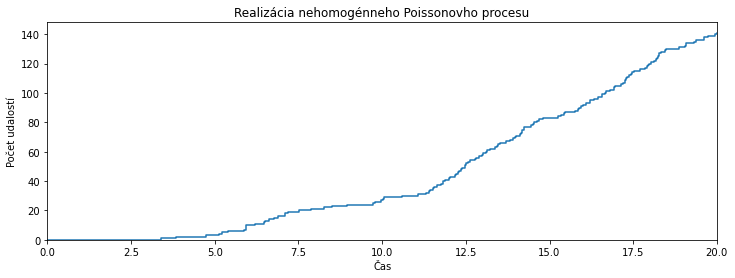

In [5]:
# definicia funkcie
xp = [0, 5, 8, 8, 10, 12, 20]
yp = [0, 5, 6, 3, 3, 14, 10]
max_time = 20

# delenie
partition, lambdas = make_optimal_partition(xp, yp, R=0.95, k_max=100)

# simulacia zamietacou metodou
events = rejection_method(xp, yp, T=max_time, partition=partition, lambdas=lambdas)

# vykreslenie
plot_poisson(events, max_time)

<a id=algo_inverse><a>
## Algoritmus simulácie inverznou transformáciou (Klein a Roberts)
<blockquote>

1. Nech $\lambda(t)$ je spojitá a nezáporná po častiach lineárna funkcia intenzity na intervale $[0,T]$ definovaná koncovými bodmi jednotlivých lineárnych funkcií $[t_i,\lambda_i], i=0,1,\dots,k$, $0=t_0<t_1< \dots < t_k = T$.
2. Pre každý interval $[t_{i-1},t_i],\ i=1,2,\dots, k$ určíme koeficienty $a_i$, $b_i$ lineárnej funkcie v tvare $a_it+b_i$ na danom intervale
3. Položíme $t=0$ (aktuálny čas) a $i=1$ (aktuálny interval).
4. Generujeme náhodné číslo $u$ z intervalu $[0,1]$ a položíme $u_k = 1-e^{-\frac{a_i(t_i^2-t^2)}{2}-b_i(t_i-t)}$
5. Pokým platí $u>u_k$, opakujeme:
    - Položíme $u=\dfrac{u-u_k}{1-u_k}$ a $i=i+1$.
	- Ak $i>k$, tak končíme algoritmus,
		inak položíme $t=t_{i-1}$ a $u_k = 1-e^{-\frac{a_i(t_i^2-t^2)}{2}-b_i(t_i-t)}$
6. Položíme $t=\begin{cases}
	\dfrac{-b_i+\sqrt{b_i^2+a_i^2+t^2+2a_ib_it-2a_i\ln{(1-u)}}}{2}\qquad\text{ak }a_i\neq0;\\
	t-\dfrac{\ln{(1-u)}}{b_i}\qquad\text{ak }a_i=0
	\end{cases}$
	- Ak $t<T$, určíme $t$ ako čas udalosti a pokračujeme 4. bodom,
	inak končíme algoritmus.

Výstupom je opäť množina časov, ktoré predstavujú časy jednotlivých udalostí.
</blockquote>

Implementácia v Python-e:

In [6]:
def klein_roberts(xp, yp, T):
    rng = np.random.default_rng()

    # zapis intervalov iba nenulovej dlzky
    ints = [Interval(a, b, f_a, f_b) for a, b, f_a, f_b in zip(xp[:-1], xp[1:], yp[:-1], yp[1:]) if
            not np.isclose(b - a, 0)]

    arrivals = []
    act_time = 0
    i = 0

    while True:
        u = rng.random()

        u_k = 1 - np.exp(
            -(ints[i].slope / 2) * (ints[i].b ** 2 - act_time ** 2) - ints[i].intercept * (ints[i].b - act_time))

        while u > u_k:
            u = (u - u_k) / (1 - u_k)
            i += 1
            if i < len(ints):
                act_time = ints[i].a
                u_k = 1 - np.exp(-(ints[i].slope / 2) * (ints[i].b ** 2 - act_time ** 2) - ints[i].intercept * (
                        ints[i].b - act_time))
            else:
                return np.array(arrivals)

        a, b = ints[i].slope, ints[i].intercept
        if np.isclose(a, 0):
            act_time = act_time - np.log(1 - u) / b
        else:
            act_time = (-b + np.sqrt(
                b ** 2 + a ** 2 * act_time ** 2 + 2 * a * b * act_time - 2 * a * np.log(1 - u))) / a
        if act_time < T:
            arrivals.append(act_time)
        else:
            return np.array(arrivals)

Opäť ukážeme simuláciu na rovnakej funkcii intenzity.

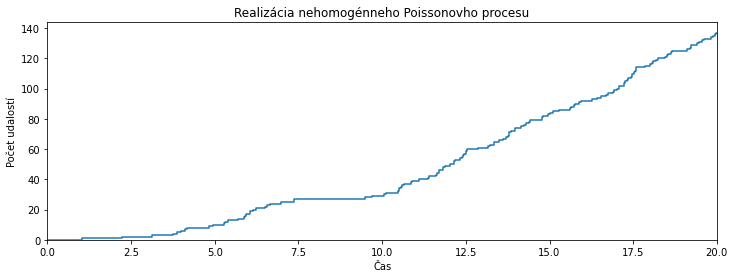

In [7]:
# definicia funkcie
xp = [0, 5, 8, 8, 10, 12, 20]
yp = [0, 5, 6, 3, 3, 14, 10]
max_time = 20

# simulacia
events = klein_roberts(xp, yp, T=max_time)

# vykreslenie
plot_poisson(events, max_time)

***
<a id=football><a>
## Simulácia futbalového zápasu
<blockquote>V tomto príklade bude našou úlohou simulovať priebeh futbalového zápasu. Predpokladajme, že zápas trvá vždy 95 minút (riadna hracia doba 90 minút + päťminútový nadstavený čas) a výskyt gólov počas futbalového zápasu sa riadi Poissonovým procesom s nasledujúcou funkciou intenzity:
$$\lambda(t)=\begin{cases}
\hspace{9pt}0.0001t+0.027, \qquad \text{ak }0 < t \le 15;\\
\hspace{9pt}0.0003t+0.024, \qquad \text{ak }15 < t \le 60;\\
\hspace{9pt}0.0005t+0.018, \qquad \text{ak }30 < t \le 45;\\
-0.0001t+0.040, \qquad \text{ak }45 < t \le 60;\\
-0.0002t+0.046, \qquad \text{ak }60 < t \le 75;\\
\hspace{9pt}0.0002t+0.016, \qquad \text{ak }75 < t \le 95.\\
\end{cases}$$
Historicky, 57% všetkých gólov strelil domáci tím. Predpokladajme teda, že ak padne gól v zápase, tak pravdepodobnosť, že ho strelia domáci je $p_d=0.57$. Analogicky, pre hostí $p_h=0.43$.</blockquote>

In [8]:
# zapis funkcie intenzity

def intensity_f(t):
    if 0 <= t <= 15:
        return 0.0001 * t + 0.027
    if 15 < t <= 30:
        return 0.0003 * t + 0.024
    if 30 < t <= 45:
        return 0.0005 * t + 0.018
    if 45 < t <= 60:
        return -0.0001 * t + 0.040
    if 60 < t <= 75:
        return -0.0002 * t + 0.046
    if 75 < t <= 95:
        return 0.0002 * t + 0.016
    return 0


#pozor na skok v 45. minute, pouzijeme eps pre limitu sprava
eps = 1e-10
xp = [0, 15, 30, 45, 45 + eps, 60, 75, 95]
yp = list(map(intensity_f, xp))

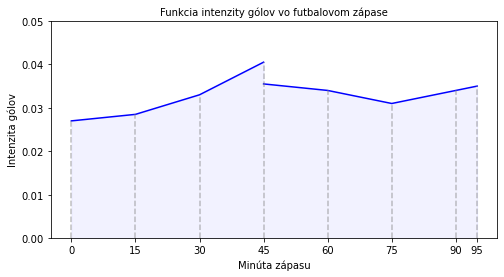

In [9]:
# vykreslenie funkcie intenzity
plot_football_intensity_function(xp, yp)

Následne sa pokúsime empiricky overiť odpovede na tieto otázky:
1. Aký je očakávaný počet gólov v zápase?
2. Aká je pravdepodobnosť remízy alebo výhry domácich či hostí?
3. Aká je pravdepodobnosť, že v zápase nepadne žiaden gól? A aká, že padne gól v nadstavenom čase?

In [10]:
def football_match_sim(xp, yp, p_d=0.57):
    """
    Simulacia futbaloveho zapasu ako realizacia nehomogenneho Poissonovho procesu.
    
    :param xp: x-ove suradnice bodov funkcie intenzity (po castiach linearnej)
    :param yp: y-ove suradnice bodov funkcie intenzity (po castiach linearnej)
    :param p_d: Pravdepodobnost golu domacich
    :return: Pole dvojic (t,k), kde t je cas golu a k je hodnota "D" (domaci) alebo "H" (hostia) - muzstvo, ktore gol strelilo
    """
    rng = np.random.default_rng()

    partition, lambdas = make_optimal_partition(xp, yp)

    goal_times = rejection_method(xp, yp, T=95, partition=partition, lambdas=lambdas)
    goal_teams = rng.choice(["D", "H"], size=len(goal_times), p=[p_d, 1 - p_d])
    return list(zip(goal_times, goal_teams))

Niekoľko ilustračných realizácií:

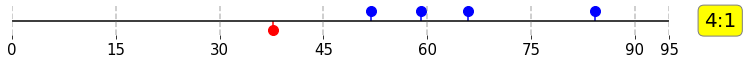

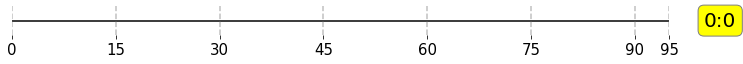

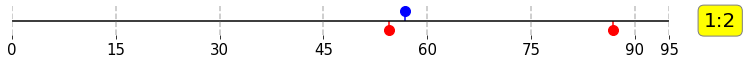

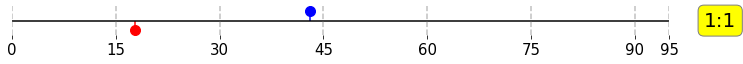

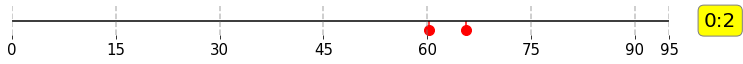

In [14]:
for _ in range(5):
    football_goal_timeline(football_match_sim(xp, yp))

In [12]:
# volitelny parameter N - pocet realizacii
N = 10_000

# pocitadla meranych velicin
n_of_goals = 0
n_of_home_wins = 0
n_of_away_wins = 0
n_of_draws = 0
n_of_goalless_matches = 0
n_of_extratime_goal_matches = 0

# simulacia 
for _ in range(N):
    goals = football_match_sim(xp, yp)

    home_goals = [t for t, k in goals if k == "D"]
    away_goals = [t for t, k in goals if k == "H"]

    if len(home_goals) == len(away_goals):
        n_of_draws += 1
    elif len(home_goals) > len(away_goals):
        n_of_home_wins += 1
    else:
        n_of_away_wins += 1

    n_of_goals += len(goals)
    if len(goals) == 0:
        n_of_goalless_matches += 1

    for time in home_goals + away_goals:
        if time > 90:
            n_of_extratime_goal_matches += 1
            break

# vypis empirickych hodnot
print(f"\t\t\t\t\t\t\tSkutocna hodnota\tEmpiricka hodnota")
print(f"Priemerny pocet golov v zapase:\t\t\t\t3.0975\t\t\t{n_of_goals / N:.4f}")
print(f"Pravdepodobnost remizy:\t\t\t\t\t0.232755\t\t{n_of_draws / N}")
print(f"Pravdepodobnost vyhry domacich:\t\t\t\t0.476968\t\t{n_of_home_wins / N}")
print(f"Pravdepodobnost vyhry hosti:\t\t\t\t0.290277\t\t{n_of_away_wins / N}")
print(f"Pravdepodobnost, ze nepadne ziaden gol:\t\t\t0.045162\t\t{n_of_goalless_matches / N}")
print(f"Pravdepodobnost, ze padne gol v nadstavenom case:\t0.158442\t\t{n_of_extratime_goal_matches / N}")

							Skutocna hodnota	Empiricka hodnota
Priemerny pocet golov v zapase:				3.0975			3.0945
Pravdepodobnost remizy:					0.232755		0.2359
Pravdepodobnost vyhry domacich:				0.476968		0.4751
Pravdepodobnost vyhry hosti:				0.290277		0.289
Pravdepodobnost, ze nepadne ziaden gol:			0.045162		0.0457
Pravdepodobnost, ze padne gol v nadstavenom case:	0.158442		0.1548
